<a href="https://colab.research.google.com/github/Aryannovice/R-Dsubmission/blob/main/FLAMR%26D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares

In [37]:
df = pd.read_csv("xy_data.csv")

In [38]:
x_obs = df['x'].to_numpy()
y_obs = df['y'].to_numpy()
K = len(x_obs)

In [39]:
t = 6.0 + np.arange(K) * (60.0 - 6.0) / (K - 1) #we do parametrization for this

In [40]:
def S_func(t, M):
    return np.exp(M * t) * np.sin(0.3 * t)

In [41]:
def model_xy(params, t):

    theta, M, X = params   # params are as follows - [theta_rad, M, X]
    S = S_func(t, M)
    x_pred = t * np.cos(theta) - S * np.sin(theta) + X
    y_pred = 42.0 + t * np.sin(theta) + S * np.cos(theta)
    return x_pred, y_pred

we define the fucntions separately from here onwards as well as S_func and model_xy.[link text](https://)

In [42]:
def residuals(params, t, x_obs, y_obs):
    x_pred, y_pred = model_xy(params, t)
    res = np.empty(2 * t.size)
    res[0::2] = x_pred - x_obs
    res[1::2] = y_pred - y_obs
    return res

In [43]:
def jac(params, t, x_obs=None, y_obs=None):
    theta, M, X = params
    S = S_func(t, M)
    St = np.exp(M * t) * (M * np.sin(0.3 * t) + 0.3 * np.cos(0.3 * t))
    dxdtheta = -t * np.sin(theta) - S * np.cos(theta)
    dydtheta = t * np.cos(theta) - S * np.sin(theta)
    dxdM = -t * S * np.sin(theta)
    dydM = t * S * np.cos(theta)
    dxdX = np.ones_like(t)
    dydX = np.zeros_like(t)
    J = np.zeros((2 * t.size, 3))
    J[0::2, 0] = dxdtheta
    J[1::2, 0] = dydtheta
    J[0::2, 1] = dxdM
    J[1::2, 1] = dydM
    J[0::2, 2] = dxdX
    J[1::2, 2] = dydX
    return J

In [44]:
theta0_deg = 30.0
theta0 = np.deg2rad(theta0_deg)
M0 = 0.0
X0 = float(np.mean(x_obs))
p0 = np.array([theta0, M0, X0])

In [45]:
lower = np.array([np.deg2rad(1e-6), -0.05, 0.0])
upper = np.array([np.deg2rad(50.0 - 1e-6), 0.05, 100.0])

In [46]:
res = least_squares(
    residuals, p0, jac=jac, bounds=(lower, upper),
    args=(t, x_obs, y_obs), method='trf', verbose=2, xtol=1e-10, ftol=1e-10
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.9993e+05                                    3.59e+06    
       1              2         4.2505e+05      5.75e+05       2.07e+01       6.67e+05    
       2              3         3.8689e+05      3.82e+04       6.69e+00       6.31e+04    
       3              4         3.8589e+05      1.00e+03       1.13e+00       4.82e+03    
       4              5         3.8585e+05      4.63e+01       1.07e-01       1.19e+03    
       5              6         3.8584e+05      3.53e+00       2.31e-02       2.84e+02    
       6              7         3.8584e+05      1.38e-01       5.58e-03       6.83e+01    
       7              8         3.8584e+05      6.82e-03       1.35e-03       1.64e+01    
       8              9         3.8584e+05      3.90e-04       3.24e-04       3.93e+00    
       9             10         3.8584e+05      2.25e-05       7.76e-05       9.43e-01    

In [47]:
theta_hat, M_hat, X_hat = res.x
theta_hat_deg = np.rad2deg(theta_hat)
print("Solution:")
print("theta (deg) =", theta_hat_deg)
print("theta (rad) =", theta_hat)
print("M =", M_hat)
print("X =", X_hat)

Solution:
theta (deg) = 29.582904586644666
theta (rad) = 0.5163190873402815
M = -0.049999999999999996
X = 55.01363528027667


In [48]:
r = res.fun
RSS = np.sum(r**2)
m = r.size        # 2K
p = 3
sigma2_hat = RSS / (m - p)
print("RSS =", RSS)
print("sigma^2_hat =", sigma2_hat)

RSS = 771686.8923660434
sigma^2_hat = 257.48645057258705


In [49]:
J = res.jac  #which is of the shape since its a matrix (2K,3)
JTJ = J.T @ J

In [50]:
cov_approx = sigma2_hat * np.linalg.pinv(JTJ)
stderr = np.sqrt(np.diag(cov_approx))
print("Approx covariance matrix:\n", cov_approx)
print("Std errors:", stderr)

Approx covariance matrix:
 [[ 1.61288657e-04  6.57367065e-05  2.61830292e-03]
 [ 6.57367065e-05  1.02426794e-02 -2.90696237e-04]
 [ 2.61830292e-03 -2.90696237e-04  2.14342713e-01]]
Std errors: [0.01269995 0.10120612 0.46297161]


In [51]:
x_pred, y_pred = model_xy(res.x, t)
L1 = np.mean(np.abs(x_pred - x_obs) + np.abs(y_pred - y_obs))
print("L1 =", L1)

L1 = 25.401465673997308


In [52]:
np.savez("fit_results.npz", params=res.x, cov=cov_approx, RSS=RSS, L1=L1)

In [53]:
import matplotlib.pyplot as plt

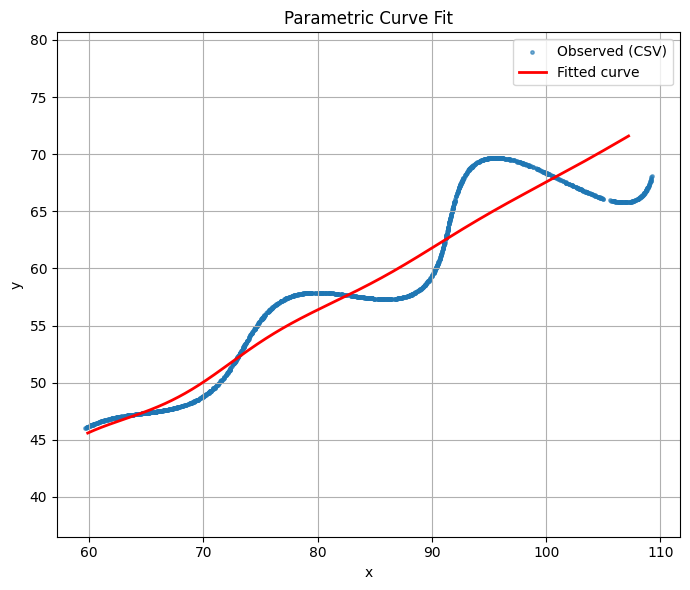

In [54]:
plt.figure(figsize=(7,6))
plt.scatter(x_obs, y_obs, s=6, label="Observed (CSV)", alpha=0.6)
plt.plot(x_pred, y_pred, color="red", lw=2, label="Fitted curve")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Parametric Curve Fit")
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()

plt.show()

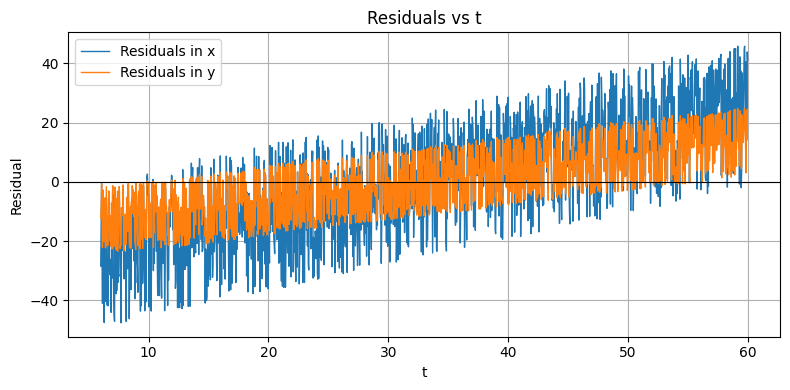

In [55]:
res_x = x_pred - x_obs
res_y = y_pred - y_obs
plt.figure(figsize=(8,4))
plt.plot(t, res_x, label="Residuals in x", lw=1)
plt.plot(t, res_y, label="Residuals in y", lw=1)
plt.axhline(0, color="black", lw=0.8)
plt.xlabel("t")
plt.ylabel("Residual")
plt.title("Residuals vs t")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("residuals_vs_t.png", dpi=300)
plt.show()

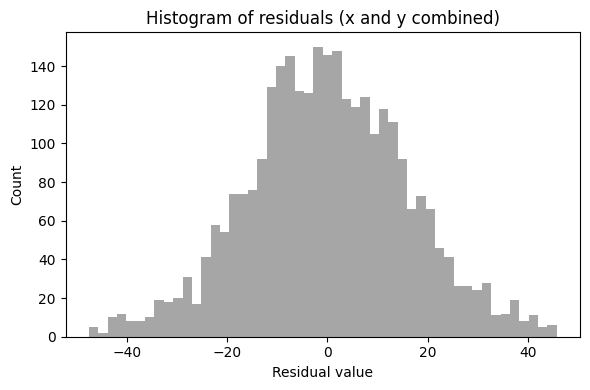

In [56]:
plt.figure(figsize=(6,4))
plt.hist(np.hstack([res_x, res_y]), bins=50, color="gray", alpha=0.7)
plt.title("Histogram of residuals (x and y combined)")
plt.xlabel("Residual value")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("residual_hist.png", dpi=300)
plt.show()

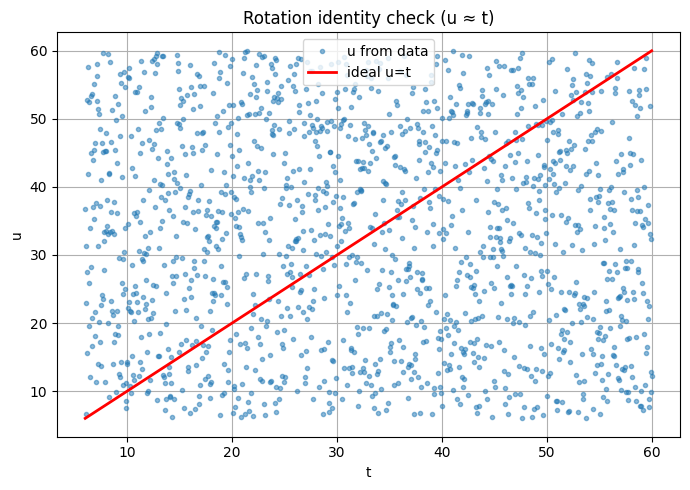

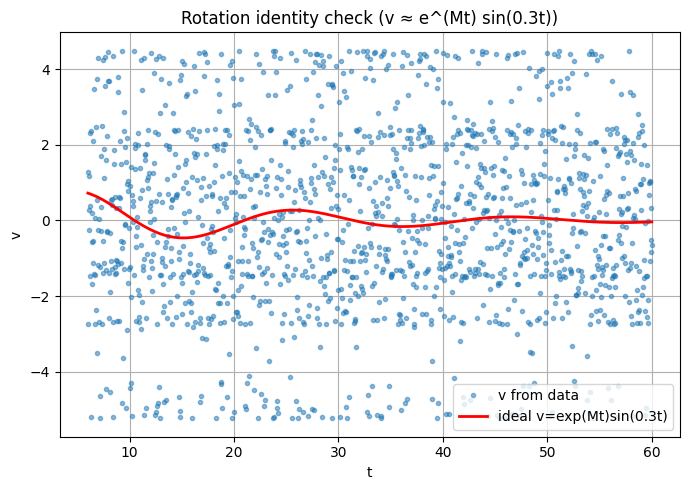

In [57]:
theta = theta_hat
X = X_hat
M = M_hat
u = (x_obs - X) * np.cos(theta) + (y_obs - 42) * np.sin(theta)
v = -(x_obs - X) * np.sin(theta) + (y_obs - 42) * np.cos(theta)
plt.figure(figsize=(7,5))
plt.plot(t, u, '.', label="u from data", alpha=0.5)
plt.plot(t, t, 'r-', lw=2, label="ideal u=t")
plt.xlabel("t")
plt.ylabel("u")
plt.legend()
plt.title("Rotation identity check (u ≈ t)")
plt.grid(True)
plt.tight_layout()
plt.savefig("u_check.png", dpi=300)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(t, v, '.', label="v from data", alpha=0.5)
plt.plot(t, np.exp(M*t)*np.sin(0.3*t), 'r-', lw=2, label="ideal v=exp(Mt)sin(0.3t)")
plt.xlabel("t")
plt.ylabel("v")
plt.legend()
plt.title("Rotation identity check (v ≈ e^(Mt) sin(0.3t))")
plt.grid(True)
plt.tight_layout()
plt.savefig("v_check.png", dpi=300)
plt.show()